In [44]:
# """Student_Score_Prediction.ipynb
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Load the dataset
try:
    # Try to load from a file (update the path to your dataset)
    df = pd.read_csv('/content/student_performance_dataset.csv')
    print("Dataset loaded from file")
except:
    # Create sample data if file not found
    print("File not found, creating sample data...")
    np.random.seed(42)
    n_students = 300

    # Generate synthetic data
    study_hours = np.random.normal(5, 2, n_students)
    study_hours = np.clip(study_hours, 1, 10)  # Ensure values between 1-10

    sleep_hours = np.random.normal(7, 1.5, n_students)
    sleep_hours = np.clip(sleep_hours, 4, 10)  # Ensure values between 4-10

    participation = np.random.uniform(0, 100, n_students)  # Participation percentage
    previous_scores = np.random.normal(70, 15, n_students)  # Previous exam scores
    previous_scores = np.clip(previous_scores, 0, 100)

    # Create final score with some noise
    final_score = (study_hours * 6 +
                  sleep_hours * 1.5 +
                  participation * 0.15 +
                  previous_scores * 0.3 +
                  np.random.normal(0, 5, n_students))
    final_score = np.clip(final_score, 0, 100)  # Ensure scores between 0-100

    # Create DataFrame
    df = pd.DataFrame({
        'study_hours': study_hours,
        'sleep_hours': sleep_hours,
        'participation': participation,
        'previous_scores': previous_scores,
        'final_score': final_score
    })

# Display first few rows
print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

Dataset loaded from file
Dataset Overview:
  Student_ID  Gender  Study_Hours_per_Week  Attendance_Rate  Past_Exam_Scores  \
0       S147    Male                    31        68.267841                86   
1       S136    Male                    16        78.222927                73   
2       S209  Female                    21        87.525096                74   
3       S458  Female                    27        92.076483                99   
4       S078  Female                    37        98.655517                63   

  Parental_Education_Level Internet_Access_at_Home Extracurricular_Activities  \
0              High School                     Yes                        Yes   
1                      PhD                      No                         No   
2                      PhD                     Yes                         No   
3                Bachelors                      No                         No   
4                  Masters                      No               

Missing values in each column:
Student_ID                    0
Gender                        0
Study_Hours_per_Week          0
Attendance_Rate               0
Past_Exam_Scores              0
Parental_Education_Level      0
Internet_Access_at_Home       0
Extracurricular_Activities    0
Final_Exam_Score              0
Pass_Fail                     0
dtype: int64


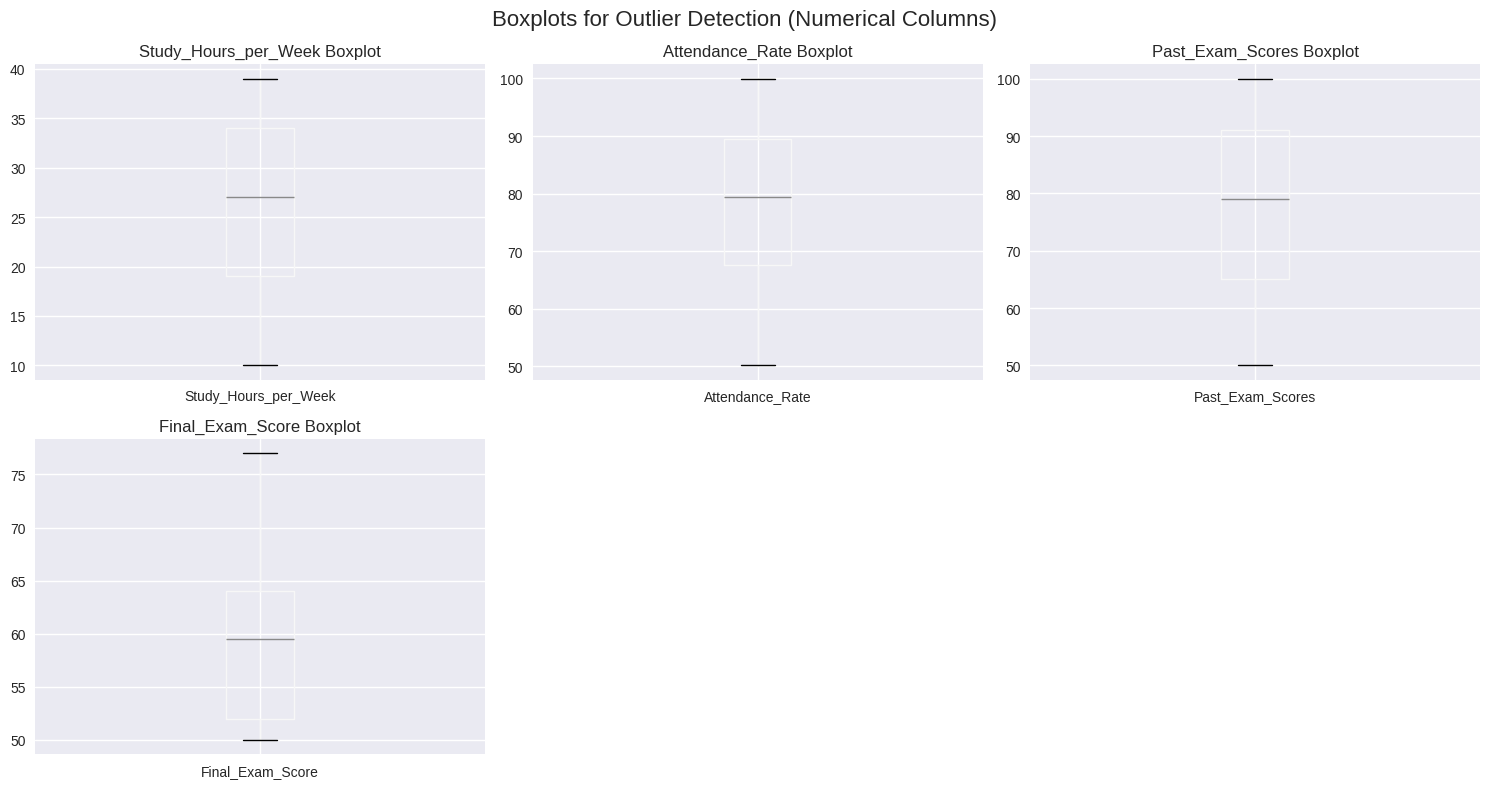


Outliers handled using IQR method for numerical columns.


In [46]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values if any
if df.isnull().sum().any():
    print("\nHandling missing values...")
    # For numerical columns, fill with median
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

# Check for outliers (only for numerical columns)
numerical_cols = df.select_dtypes(include=np.number).columns
if len(numerical_cols) > 0:
    fig, axes = plt.subplots(nrows=(len(numerical_cols) + 2) // 3, ncols=3, figsize=(15, 8))
    fig.suptitle('Boxplots for Outlier Detection (Numerical Columns)', fontsize=16)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, col in enumerate(numerical_cols):
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'{col} Boxplot')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("\nNo numerical columns found for outlier detection.")


# Handle outliers (using IQR method - only for numerical columns)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                         np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

if len(numerical_cols) > 0:
    for col in numerical_cols:
        df = handle_outliers(df, col)
    print("\nOutliers handled using IQR method for numerical columns.")
else:
    print("\nNo numerical columns found for outlier handling.")

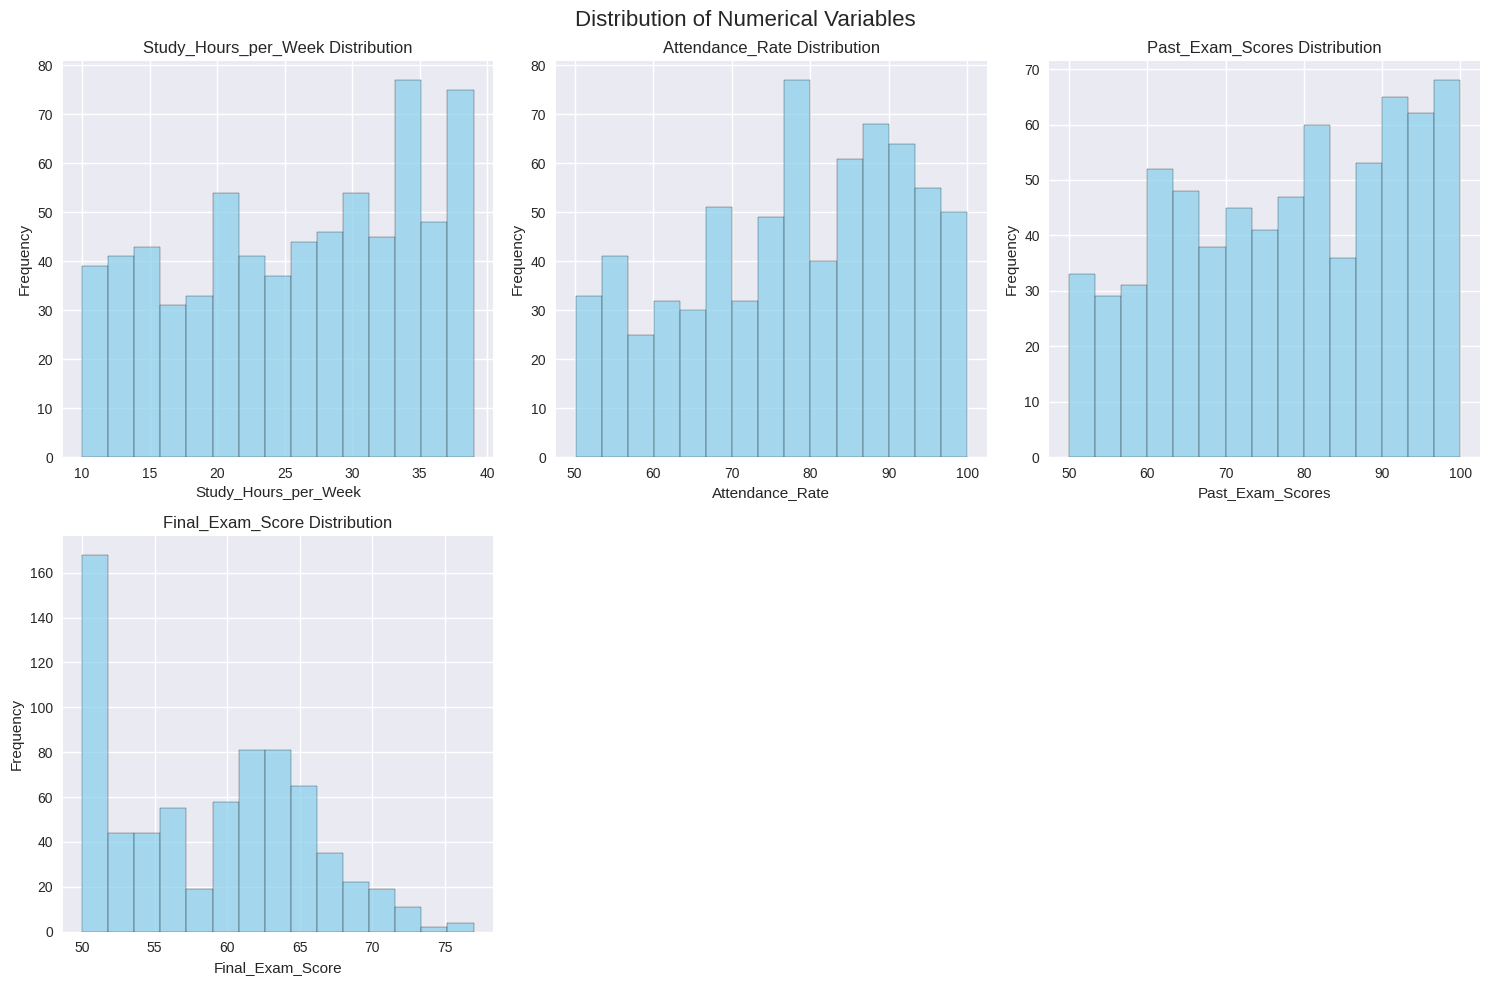

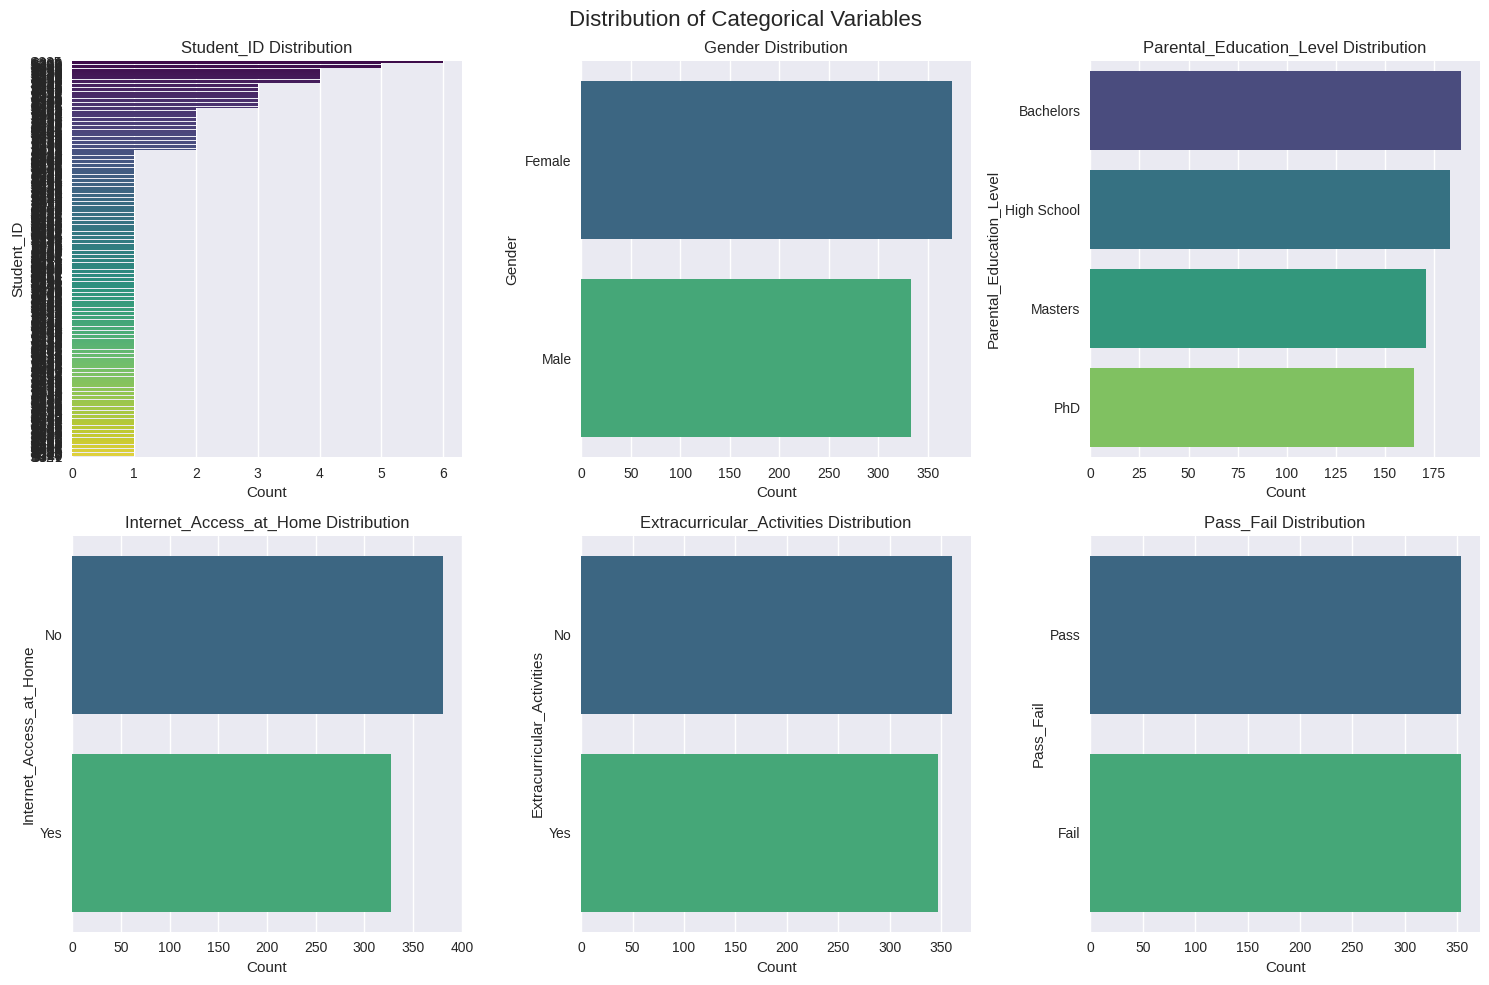

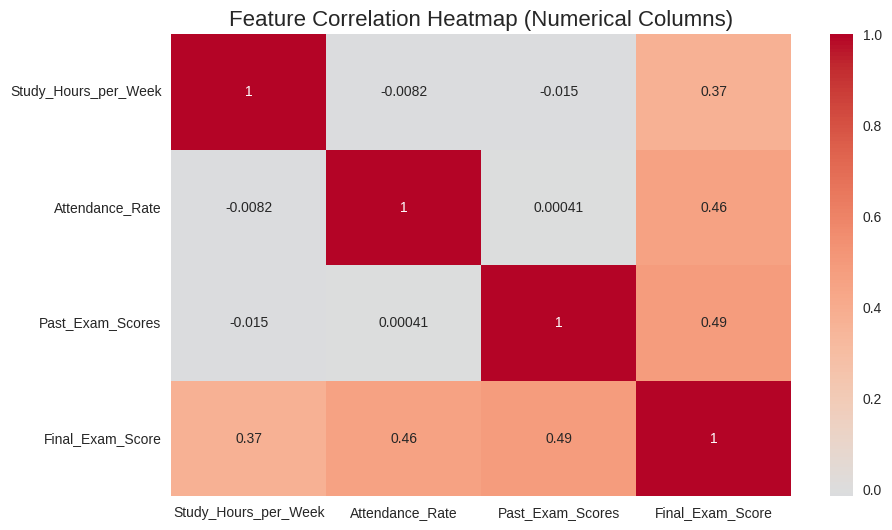

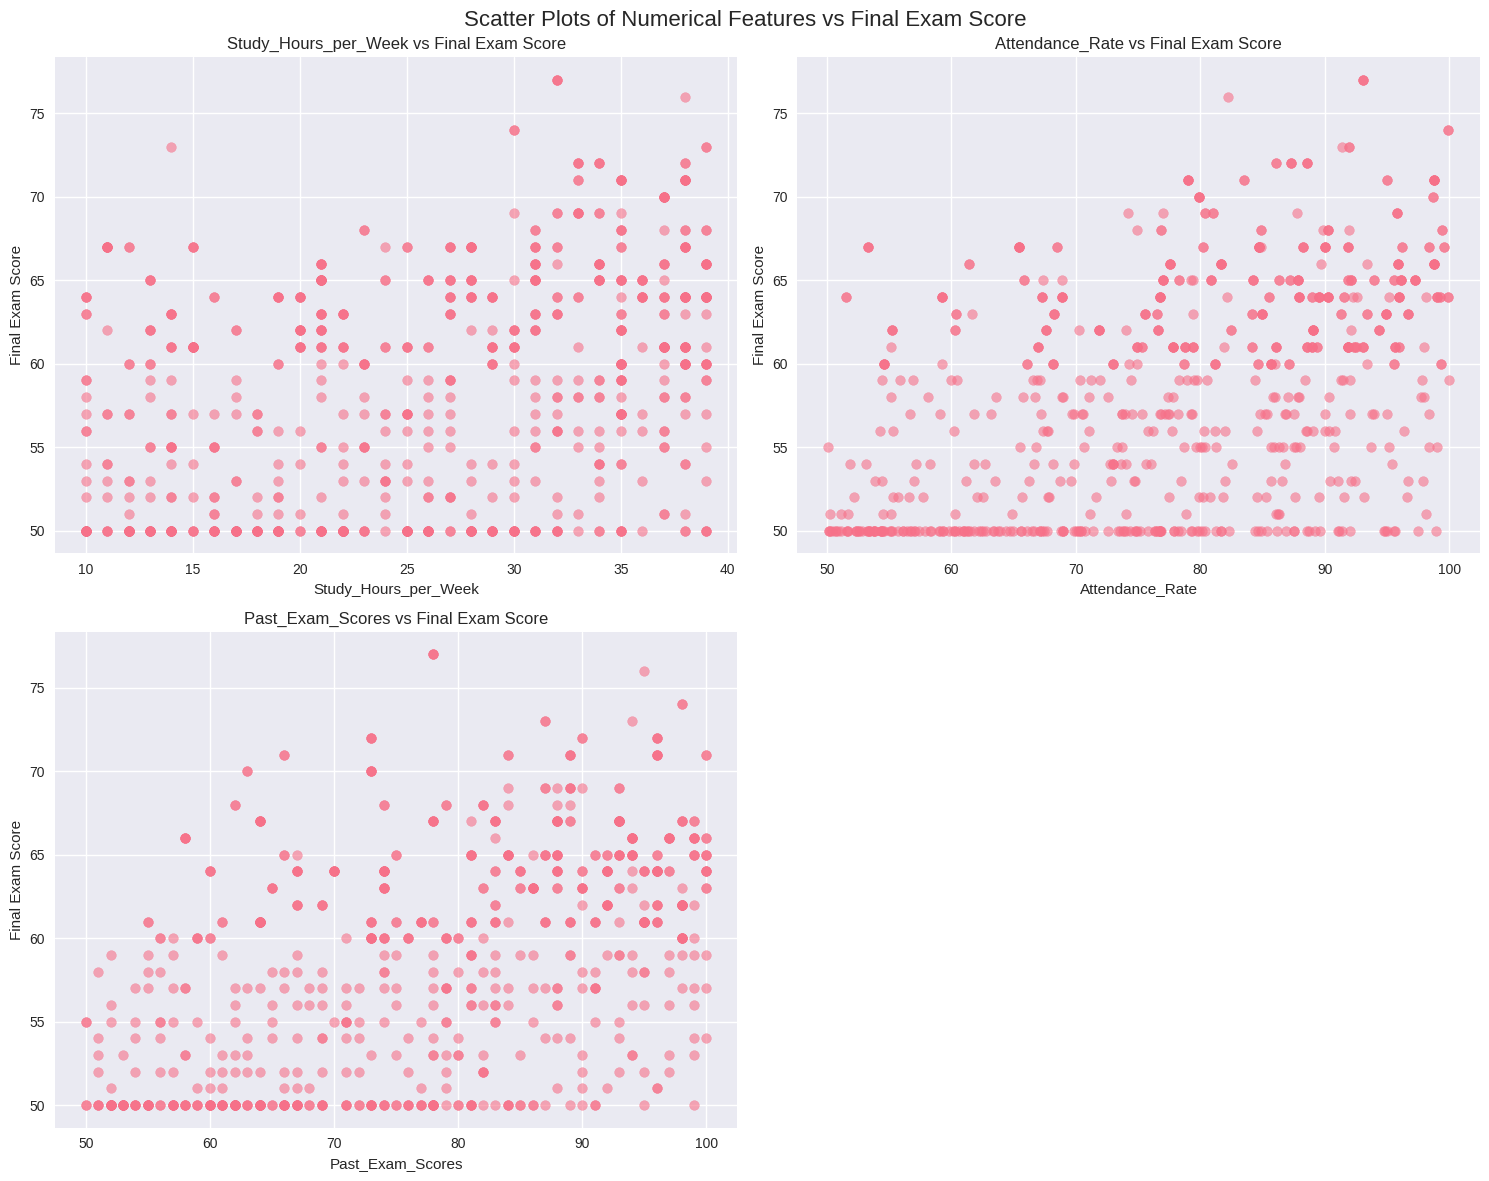

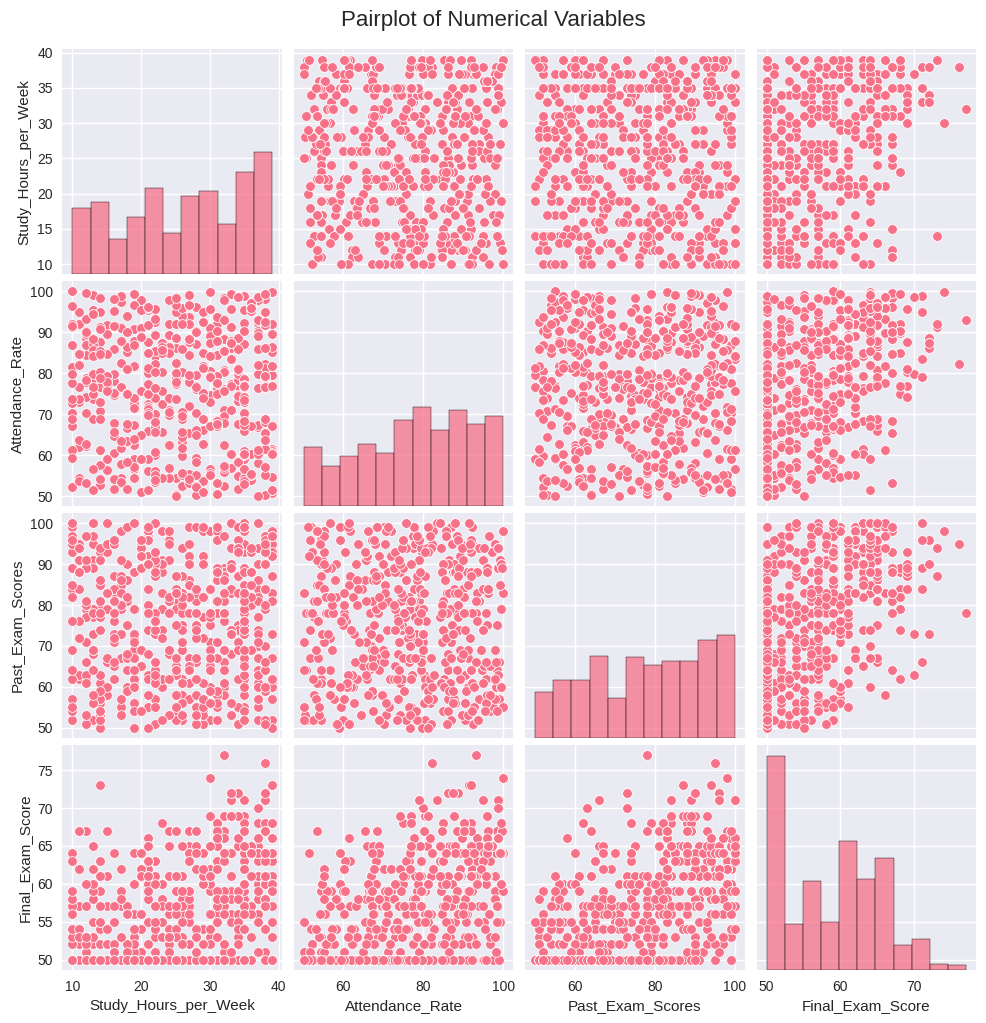

In [47]:
# Distribution of variables
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

# Plot distributions of numerical variables
if len(numerical_cols) > 0:
    n_numeric_cols = len(numerical_cols)
    n_rows_numeric = (n_numeric_cols + 2) // 3  # Calculate number of rows needed
    fig, axes = plt.subplots(nrows=n_rows_numeric, ncols=3, figsize=(15, n_rows_numeric * 5))
    fig.suptitle('Distribution of Numerical Variables', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        axes[i].hist(df[col], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("\nNo numerical columns to display distribution.")

# Plot distributions of categorical variables
if len(categorical_cols) > 0:
    n_categorical_cols = len(categorical_cols)
    n_rows_categorical = (n_categorical_cols + 2) // 3  # Calculate number of rows needed
    fig, axes = plt.subplots(nrows=n_rows_categorical, ncols=3, figsize=(15, n_rows_categorical * 5))
    fig.suptitle('Distribution of Categorical Variables', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(y=col, data=df, ax=axes[i], order=df[col].value_counts().index, palette='viridis')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("\nNo categorical columns to display distribution.")


# Correlation heatmap (only for numerical columns)
if len(numerical_cols) > 1:
    plt.figure(figsize=(10, 6))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap (Numerical Columns)', fontsize=16)
    plt.show()
else:
    print("\nNot enough numerical columns to display correlation heatmap.")

# Scatter plots to visualize relationships (only for numerical columns)
if len(numerical_cols) > 1:
    # Select numerical columns excluding the target variable for scatter plots
    scatter_cols = [col for col in numerical_cols if col != 'Final_Exam_Score']
    if len(scatter_cols) > 0:
        n_scatter_cols = len(scatter_cols)
        n_rows_scatter = (n_scatter_cols + 1) // 2  # Calculate number of rows needed for 2 columns per row
        fig, axes = plt.subplots(nrows=n_rows_scatter, ncols=2, figsize=(15, n_rows_scatter * 6))
        fig.suptitle('Scatter Plots of Numerical Features vs Final Exam Score', fontsize=16)
        axes = axes.flatten()

        for i, col in enumerate(scatter_cols):
            axes[i].scatter(df[col], df['Final_Exam_Score'], alpha=0.6)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Final Exam Score')
            axes[i].set_title(f'{col} vs Final Exam Score')

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
    else:
        print("\nNo numerical features (excluding target) for scatter plots.")
else:
    print("\nNot enough numerical columns for scatter plots.")


# Pairplot to visualize all relationships (only for numerical columns)
if len(numerical_cols) > 1:
    sns.pairplot(df[numerical_cols])
    plt.suptitle('Pairplot of Numerical Variables', y=1.02, fontsize=16)
    plt.show()
else:
     print("\nNot enough numerical columns for pairplot.")

In [48]:
# Define features and target variable
# Drop 'Student_ID' as it's just an identifier
X = df.drop(['Final_Exam_Score', 'Student_ID'], axis=1)
y = df['Final_Exam_Score']

# Handle categorical features using one-hot encoding
X = pd.get_dummies(X, columns=['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities', 'Pass_Fail'], drop_first=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 566
Testing set size: 142


In [49]:
# Check if target variable has non-numeric values
print("Target variable info:")
print(f"Data type: {y_train.dtype}")
print(f"Sample values: {y_train.head()}")

# Convert target variable to numeric if needed
if y_train.dtype == 'object':
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')

    # Check for and handle any NaN values
    if y_train.isnull().any() or y_test.isnull().any():
        print("NaN values found in target variable after conversion")
        y_train = y_train.fillna(y_train.median())
        y_test = y_test.fillna(y_test.median())

Target variable info:
Data type: float64
Sample values: 522    63.0
24     62.0
480    69.0
314    60.0
239    63.0
Name: Final_Exam_Score, dtype: float64


Data types in the dataset:
Study_Hours_per_Week                    float64
Attendance_Rate                         float64
Past_Exam_Scores                        float64
Gender_Male                                bool
Parental_Education_Level_High School       bool
Parental_Education_Level_Masters           bool
Parental_Education_Level_PhD               bool
Internet_Access_at_Home_Yes                bool
Extracurricular_Activities_Yes             bool
Pass_Fail_Pass                             bool
dtype: object

Checking for non-numeric values:
Column 'Gender_Male' has 566 non-numeric values
Sample non-numeric values: [False, False, False, True, False]
Column 'Parental_Education_Level_High School' has 566 non-numeric values
Sample non-numeric values: [True, False, False, False, False]
Column 'Parental_Education_Level_Masters' has 566 non-numeric values
Sample non-numeric values: [False, False, False, False, False]
Column 'Parental_Education_Level_PhD' has 566 non-numeric values
Sam

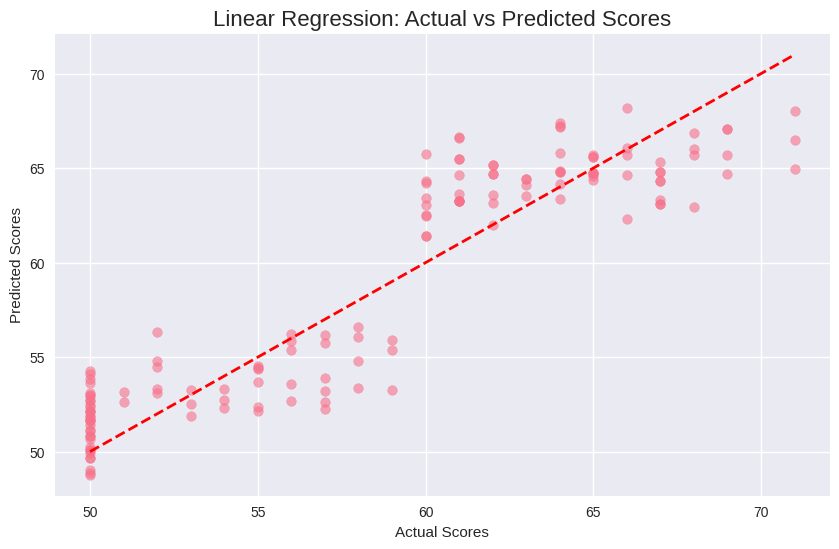

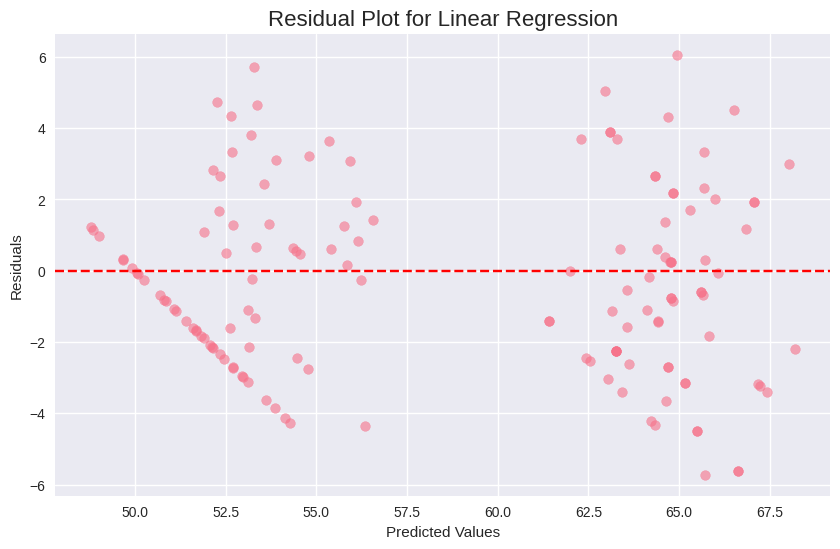


Linear Regression Coefficients:
                                Feature  Coefficient
9                        Pass_Fail_Pass     8.506751
3                           Gender_Male     0.301232
0                  Study_Hours_per_Week     0.136175
8        Extracurricular_Activities_Yes     0.110573
2                      Past_Exam_Scores     0.107523
1                       Attendance_Rate     0.099024
7           Internet_Access_at_Home_Yes     0.031930
6          Parental_Education_Level_PhD    -0.214479
5      Parental_Education_Level_Masters    -0.386076
4  Parental_Education_Level_High School    -0.847668


In [50]:
# First, let's examine the data to identify non-numeric columns
print("Data types in the dataset:")
print(X_train.dtypes)

# Check for any non-numeric values in each column
print("\nChecking for non-numeric values:")
for column in X_train.columns:
    # Check if the column contains non-numeric values
    non_numeric_count = X_train[column].apply(lambda x: not str(x).replace('.', '', 1).isdigit() if str(x).lstrip('-').replace('.', '', 1).isdigit() else True).sum()
    if non_numeric_count > 0:
        print(f"Column '{column}' has {non_numeric_count} non-numeric values")
        # Show some examples
        non_numeric_samples = X_train[column][X_train[column].apply(lambda x: not str(x).replace('.', '', 1).isdigit() if str(x).lstrip('-').replace('.', '', 1).isdigit() else True)]
        print(f"Sample non-numeric values: {non_numeric_samples.head().tolist()}")

# If you have categorical columns that need to be encoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")

if categorical_cols:
    # Option 1: Label Encoding (for ordinal categories)
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
        print(f"Label encoded column: {col}")

    # Option 2: One-Hot Encoding (for nominal categories)
    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    # X_test_encoded = encoder.transform(X_test[categorical_cols])

    # Get feature names
    # encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

    # Create DataFrames from the encoded arrays
    # X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
    # X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

    # Drop original categorical columns and concatenate with encoded ones
    # X_train = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_encoded_df], axis=1)
    # X_test = pd.concat([X_test.drop(categorical_cols, axis=1), X_test_encoded_df], axis=1)

# Check if there are still any non-numeric values
print("\nFinal data types after processing:")
print(X_train.dtypes)

# Now try training the linear regression model again
try:
    # Train linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_test)

    # Evaluate the model
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    print("Linear Regression Performance:")
    print(f"MAE: {mae_lr:.2f}")
    print(f"MSE: {mse_lr:.2f}")
    print(f"RMSE: {rmse_lr:.2f}")
    print(f"R² Score: {r2_lr:.4f}")

    # Visualize predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_lr, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Linear Regression: Actual vs Predicted Scores', fontsize=16)
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred_lr
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_lr, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Linear Regression', fontsize=16)
    plt.show()

    # Display coefficients
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr_model.coef_
    }).sort_values('Coefficient', ascending=False)

    print("\nLinear Regression Coefficients:")
    print(coefficients)

except Exception as e:
    print(f"Error during model training: {e}")
    print("Trying alternative approach...")

    # If there are still issues, try converting all columns to numeric, forcing errors
    for col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

    # Fill any NaN values created by the conversion
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_test.median())

    # Try training again
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_test)

    # Evaluate the model
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    print("Linear Regression Performance (after force conversion):")
    print(f"MAE: {mae_lr:.2f}")
    print(f"MSE: {mse_lr:.2f}")
    print(f"RMSE: {rmse_lr:.2f}")
    print(f"R² Score: {r2_lr:.4f}")